# Testing stuff in a single round

first of all lets import all necessary packages

In [8]:
import lzma
import json
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from awpy.visualization.plot import plot_map, plot_positions, position_transform
from awpy.data import MAP_DATA

### Function to read .xz archives from dataset

In [9]:
def read_parsed_demo(filename):
    with lzma.LZMAFile(filename, "rb") as f:
        d = json.load(f)
        return d

### Function to create a vector representation for a game state (also called a frame)

In [10]:
def create_frame_row(frame):
    frame_data = {}

  # Global info
    frame_data["secondsSincePhaseStart"] = frame["seconds"]
    frame_data["bombPlanted"] = frame["bombPlanted"]
    frame_data["bombsite"] = frame["bombsite"]
    frame_data["totalSmokes"] = len(frame["smokes"])
    frame_data["totalFires"] = len(frame["fires"])

    # Team specific info (CT)
    frame_data["ctAlive"] = 0
    frame_data["ctHp"] = 0
    frame_data["ctArmor"] = 0
    frame_data["ctHelmet"] = 0
    frame_data["ctEq"] = 0
    frame_data["ctUtility"] = 0
    frame_data["ctEqValStart"] = 0
    frame_data["ctBombZone"] = 0
    frame_data["defusers"] = 0
    for p in frame["ct"]["players"]:
        frame_data["ctEqValStart"] += p["equipmentValueFreezetimeEnd"]
        if p["isAlive"]:
            frame_data["ctAlive"] += 1
            frame_data["ctHp"] += p["hp"]
            frame_data["ctArmor"] += p["armor"]
            frame_data["ctHelmet"] += p["hasHelmet"]
            frame_data["ctEq"] += p["equipmentValue"]
            frame_data["ctUtility"] += p["totalUtility"]
            frame_data["defusers"] += p["hasDefuse"]
            if p["isInBombZone"]:
                frame_data["ctBombZone"] += 1
  
  # Team specific info (T)
    frame_data["tAlive"] = 0
    frame_data["tHp"] = 0
    frame_data["tArmor"] = 0
    frame_data["tHelmet"] = 0
    frame_data["tEq"] = 0
    frame_data["tUtility"] = 0
    frame_data["tEqValStart"] = 0
    frame_data["tHoldingBomb"] = 0
    frame_data["tBombZone"] = 0
    for p in frame["t"]["players"]:
        frame_data["tEqValStart"] += p["equipmentValueFreezetimeEnd"]
        if p["isAlive"]:
            frame_data["tAlive"] += 1
            frame_data["tHp"] += p["hp"]
            frame_data["tArmor"] += p["armor"]
            frame_data["tHelmet"] += p["hasHelmet"]
            frame_data["tEq"] += p["equipmentValue"]
            frame_data["tUtility"] += p["totalUtility"]
            if p["isInBombZone"]:
                frame_data["tBombZone"] += 1
            if p["hasBomb"]:
                frame_data["tHoldingBomb"] = 1

    return frame_data

### Function to create a set representation of a game state. 
Each element in the set is a vector of [global info, player-specific info]

In [11]:
def create_frame_set(frame, map_name):
  # Global info
    seconds = frame["seconds"]
    bomb_planted = 0
    if frame["bombPlanted"]:
        bomb_planted = 1
    bombsite_none = 0
    bombsite_a = 0
    bombsite_b = 0
    if frame["bombsite"] == "":
        bombsite_none = 1
    if frame["bombsite"] == "A":
        bombsite_a = 1
    if frame["bombsite"] == "B":
        bombsite_b = 1

    total_smokes = len(frame["smokes"])
    total_fires = len(frame["fires"])

  # Player specific info
    player_list = []
    for p in frame["ct"]["players"]:
        helmet = 0
        if p["hasHelmet"]:
            helmet = 1
        kit = 0
        if p["hasDefuse"]:
            kit = 1
        bomb = 0
        if p["hasBomb"]:
            bomb = 1
        in_bomb_zone = 0
        if p["isInBombZone"]:
            in_bomb_zone = 1

        has_rifle = 0
        has_smg = 0
        has_heavy = 0
        if p["inventory"]:
            for w in p["inventory"]:
                if w["weaponClass"] == "Rifle":
                    has_rifle = 1
                if w["weaponClass"] == "SMG":
                    has_smg = 1
                if w["weaponClass"] == "Heavy":
                    has_heavy = 1

        player_vec = [
                      seconds,
                      bomb_planted,
                      bombsite_none,
                      bombsite_a,
                      bombsite_b,
                      p["x"],
                      p["y"],
                      p["z"],
                      p["velocityX"],
                      p["velocityY"],
                      p["velocityZ"],
                      p["viewX"],
                      p["viewY"],
                      total_smokes,
                      total_fires,
                      1, # 1 for CT, 0 for T
                      p["hp"],
                      p["armor"],
                      helmet,
                      p["equipmentValue"],
                      p["equipmentValueFreezetimeEnd"],
                      p["equipmentValueRoundStart"],
                      p["cash"],
                      p["cashSpendThisRound"],
                      has_rifle,
                      has_smg,
                      has_heavy,
                      p["ping"],
                      len(p["spotters"]),
                      p["totalUtility"],
                      kit,
                      bomb,
                      in_bomb_zone,
                      1 if p["isBlinded"] else 0,
                      1 if p["isStanding"] else 0,
                      1 if p["isScoped"] else 0,
                      1 if p["isWalking"] else 0,
                      1 if p["isDucking"] else 0,
                      1 if p["isReloading"] else 0,
                      p["zoomLevel"]
        ]
        player_list.append(np.array(player_vec))

    for p in frame["t"]["players"]:
        helmet = 0
        if p["hasHelmet"]:
            helmet = 1
        kit = 0
        if p["hasDefuse"]:
            kit = 1
        bomb = 0
        if p["hasBomb"]:
            bomb = 1
        in_bomb_zone = 0
        if p["isInBombZone"]:
            in_bomb_zone = 1

        has_rifle = 0
        has_smg = 0
        has_heavy = 0
        if p["inventory"]:
            for w in p["inventory"]:
                if w["weaponClass"] == "Rifle":
                    has_rifle = 1
                if w["weaponClass"] == "SMG":
                    has_smg = 1
                if w["weaponClass"] == "Heavy":
                    has_heavy = 1

        player_vec = [
                      seconds,
                      bomb_planted,
                      bombsite_none,
                      bombsite_a,
                      bombsite_b,
                      p["x"],
                      p["y"],
                      p["z"],
                      p["velocityX"],
                      p["velocityY"],
                      p["velocityZ"],
                      p["viewX"],
                      p["viewY"],
                      total_smokes,
                      total_fires,
                      0, # 1 for CT, 0 for T
                      p["hp"],
                      p["armor"],
                      helmet,
                      p["equipmentValue"],
                      p["equipmentValueFreezetimeEnd"],
                      p["equipmentValueRoundStart"],
                      p["cash"],
                      p["cashSpendThisRound"],
                      has_rifle,
                      has_smg,
                      has_heavy,
                      p["ping"],
                      len(p["spotters"]),
                      p["totalUtility"],
                      kit,
                      bomb,
                      in_bomb_zone,
                      1 if p["isBlinded"] else 0,
                      1 if p["isStanding"] else 0,
                      1 if p["isScoped"] else 0,
                      1 if p["isWalking"] else 0,
                      1 if p["isDucking"] else 0,
                      1 if p["isReloading"] else 0,
                      p["zoomLevel"]
            ]
        player_list.append(np.array(player_vec))
    return np.array(player_list)

#### Looking at some properites of 1 single round
Lets print the names of the players of this round first

In [5]:
# getting the names of the players of this round

demo_files_2 = "05a57319-2185-4a18-9ad8-89b078bc48cb.json.xz"
demo = read_parsed_demo(demo_files_2)

names_ct = []
names_t = []
for r in demo["gameRounds"]:
    for frame in r["frames"]:
        for player in frame["ct"]["players"]:
            names_ct.append(player["name"])
        for player in frame["t"]["players"]:
            names_t.append(player["name"])
        break
    break
names_ct, names_t

(['device', 'hampus', 'LNZ', 'REZ', 'Plopski'],
 ['mopoz', 'dav1g', 'alex ', 'SunPayus', 'DeathZz'])

#### Plotting the trajectories of 1 round
Firstly we will have to get the positions of each player at each points of time

In [15]:
#demo_files_1 = "01af07eb-306a-40b4-be5f-d967c38c7a0f.json.xz"
demo_files_2 = "05a57319-2185-4a18-9ad8-89b078bc48cb.json.xz"
demo = read_parsed_demo(demo_files_2)

telemetry = []
tel_0 = []
tel_1 = []
tel_2 = []
tel_3 = []
tel_4 = []

for r in demo["gameRounds"]:
    for frame in r["frames"]:
        for player in frame["t"]["players"]:
            if player["name"] == names_t[0]:
                tel_0.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_t[1]:
                tel_1.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_t[2]:
                tel_2.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_t[3]:
                tel_3.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_t[4]:
                tel_4.append([player["x"], player["y"], player["z"]])
    break
    

Now lets find out on which map we are actually analyzing this round

In [16]:
map_name = demo["mapName"]
map_name

'de_inferno'

Plotting the map alone

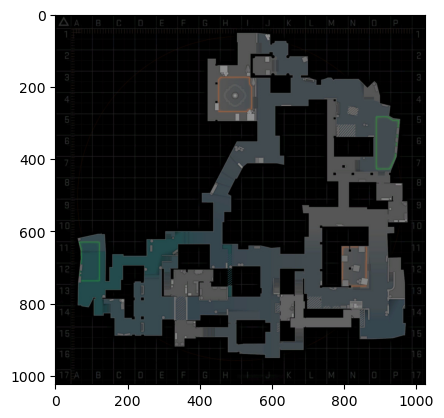

In [14]:
f, a = plot_map(map_name=map_name, map_type="original")
plt.show()

Now we have to write a function that transforms the spatio-temporal data to our map, so that we can show the trajectories of different players

In [17]:
def position_transform_all(map_name, position):
    """Transforms an X or Y coordinate.

    Args:
        map_name (string): Map to search
        position (tuple): (X,Y,Z) coordinates

    Returns:
        tuple
    """
    start_x = MAP_DATA[map_name]["x"]
    start_y = MAP_DATA[map_name]["y"]
    scale = MAP_DATA[map_name]["scale"]
    x = position[0] - start_x
    x /= scale
    y = start_y - position[1]
    y /= scale
    z = position[2]
    #if z < MAP_DATA[map_name]["z_cutoff"]:
        #y += 1024
    return (x, y, z)

Now here we actually transform the data accordingly

In [18]:
transformed_telemetry_0 = []
transformed_telemetry_1 = []
transformed_telemetry_2 = []
transformed_telemetry_3 = []
transformed_telemetry_4 = []

for frame in tel_0:
    coord = position_transform_all(map_name, position=frame)
    transformed_telemetry_0.append(coord)
    
for frame in tel_1:
    coord = position_transform_all(map_name, position=frame)
    transformed_telemetry_1.append(coord)
    
for frame in tel_2:
    coord = position_transform_all(map_name, position=frame)
    transformed_telemetry_2.append(coord)
    
for frame in tel_3:
    coord = position_transform_all(map_name, position=frame)
    transformed_telemetry_3.append(coord)
    
for frame in tel_4:
    coord = position_transform_all(map_name, position=frame)
    transformed_telemetry_4.append(coord)

In [19]:
trans_X_0 = [x[0] for x in transformed_telemetry_0]
trans_Y_0 = [x[1] for x in transformed_telemetry_0]

trans_X_1 = [x[0] for x in transformed_telemetry_1]
trans_Y_1 = [x[1] for x in transformed_telemetry_1]

trans_X_2 = [x[0] for x in transformed_telemetry_2]
trans_Y_2 = [x[1] for x in transformed_telemetry_2]

trans_X_3 = [x[0] for x in transformed_telemetry_3]
trans_Y_3 = [x[1] for x in transformed_telemetry_3]

trans_X_4 = [x[0] for x in transformed_telemetry_4]
trans_Y_4 = [x[1] for x in transformed_telemetry_4]

Now lets do the same again, but this time for the Counter Terrorists (CT)

In [20]:
demo_files_1 = "01af07eb-306a-40b4-be5f-d967c38c7a0f.json.xz"
demo_files_2 = "05a57319-2185-4a18-9ad8-89b078bc48cb.json.xz"
demo = read_parsed_demo(demo_files_2)

telemetry = []
ctel_0 = []
ctel_1 = []
ctel_2 = []
ctel_3 = []
ctel_4 = []

for r in demo["gameRounds"]:
    for frame in r["frames"]:
        for player in frame["ct"]["players"]:
            if player["name"] == names_ct[0]:
                ctel_0.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_ct[1]:
                ctel_1.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_ct[2]:
                ctel_2.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_ct[3]:
                ctel_3.append([player["x"], player["y"], player["z"]])
            elif player["name"] == names_ct[4]:
                ctel_4.append([player["x"], player["y"], player["z"]])
    break

ctransformed_telemetry_0 = []
ctransformed_telemetry_1 = []
ctransformed_telemetry_2 = []
ctransformed_telemetry_3 = []
ctransformed_telemetry_4 = []

for frame in ctel_0:
    coord = position_transform_all(map_name, position=frame)
    ctransformed_telemetry_0.append(coord)
    
for frame in ctel_1:
    coord = position_transform_all(map_name, position=frame)
    ctransformed_telemetry_1.append(coord)
    
for frame in ctel_2:
    coord = position_transform_all(map_name, position=frame)
    ctransformed_telemetry_2.append(coord)
    
for frame in ctel_3:
    coord = position_transform_all(map_name, position=frame)
    ctransformed_telemetry_3.append(coord)
    
for frame in ctel_4:
    coord = position_transform_all(map_name, position=frame)
    ctransformed_telemetry_4.append(coord)

ctrans_X_0 = [x[0] for x in ctransformed_telemetry_0]
ctrans_Y_0 = [x[1] for x in ctransformed_telemetry_0]

ctrans_X_1 = [x[0] for x in ctransformed_telemetry_1]
ctrans_Y_1 = [x[1] for x in ctransformed_telemetry_1]

ctrans_X_2 = [x[0] for x in ctransformed_telemetry_2]
ctrans_Y_2 = [x[1] for x in ctransformed_telemetry_2]

ctrans_X_3 = [x[0] for x in ctransformed_telemetry_3]
ctrans_Y_3 = [x[1] for x in ctransformed_telemetry_3]

ctrans_X_4 = [x[0] for x in ctransformed_telemetry_4]
ctrans_Y_4 = [x[1] for x in ctransformed_telemetry_4]

Finally we can plot the trajectories of both teams <br>
Here i the gree and blue trajectories are for the terrorists and the yellow, orange, red ones are for the CTs

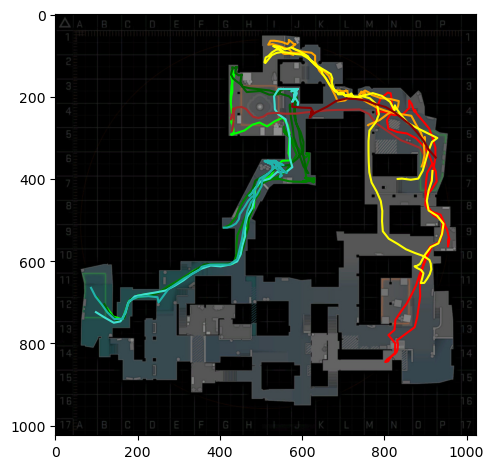

In [21]:
f, a = plot_map(map_name=map_name, map_type="original")

plt.plot(trans_X_0,trans_Y_0, color='lime')
plt.plot(trans_X_1,trans_Y_1, color='green')
plt.plot(trans_X_2,trans_Y_2, color='darkgreen')
plt.plot(trans_X_3,trans_Y_3, color='turquoise')
plt.plot(trans_X_4,trans_Y_4, color='lightseagreen')

plt.plot(ctrans_X_0,ctrans_Y_0, color='red')
plt.plot(ctrans_X_1,ctrans_Y_1, color='brown')
plt.plot(ctrans_X_2,ctrans_Y_2, color='orange')
plt.plot(ctrans_X_3,ctrans_Y_3, color='yellow')
plt.plot(ctrans_X_4,ctrans_Y_4, color='darkred')
plt.tight_layout()
plt.show()

## Creating a Dataframe out of the trajectory data

Now i combined all the data of this round and created a pandas Dataframe out of them

In [26]:
telemetry_c_0 = list(zip(trans_X_0, trans_Y_0))
telemetry_c_1 = list(zip(trans_X_1, trans_Y_1))
telemetry_c_2 = list(zip(trans_X_2, trans_Y_2))
telemetry_c_3 = list(zip(trans_X_3, trans_Y_3))
telemetry_c_4 = list(zip(trans_X_4, trans_Y_4))
telemetry_c = [telemetry_c_0, telemetry_c_1, telemetry_c_2, telemetry_c_3, telemetry_c_4]
zipped_tel_c = list(zip(telemetry_c_0, telemetry_c_1, telemetry_c_2, telemetry_c_3, telemetry_c_4))

ctelemetry_c_0 = list(zip(ctrans_X_0, ctrans_Y_0))
ctelemetry_c_1 = list(zip(ctrans_X_1, ctrans_Y_1))
ctelemetry_c_2 = list(zip(ctrans_X_2, ctrans_Y_2))
ctelemetry_c_3 = list(zip(ctrans_X_3, ctrans_Y_3))
ctelemetry_c_4 = list(zip(ctrans_X_4, ctrans_Y_4))
ctelemetry_c = [ctelemetry_c_0, ctelemetry_c_1, ctelemetry_c_2, ctelemetry_c_3, ctelemetry_c_4]
zipped_tel_ct = list(zip(ctelemetry_c_0, ctelemetry_c_1, ctelemetry_c_2, ctelemetry_c_3, ctelemetry_c_4))

In [27]:
df_t = pd.DataFrame(zipped_tel_c, range(len(telemetry_c_0)), names_t)
df_ct = pd.DataFrame(zipped_tel_ct, range(len(ctelemetry_c_0)), names_ct)

In [28]:
telemetry_c = [telemetry_c_0, telemetry_c_1, telemetry_c_2, telemetry_c_3, telemetry_c_4]

In [29]:
distance_c = np.zeros((5))
for i in range(len(telemetry_c)):
    for j in range(len(telemetry_c[i])-1):
        distance_c[i] += math.dist(telemetry_c[i][j], telemetry_c[i][j+1])
distance_c

array([1288.07552795, 1527.49457258, 1688.64363501, 1137.21327472,
       1549.59761967])

### adding the total distance as a new row

In [30]:

df_t.loc[len(df_t.index)] = distance_c
df_t

,mopoz,dav1g,alex,SunPayus,DeathZz
0,"(125.66692741549744, 714.4287358498086)","(101.81441326530611, 687.887629294882)","(118.89097875478315, 704.5327509665975)","(98.58139349489795, 723.9911885164221)","(86.60148776307398, 664.8735575773278)"
1,"(140.99362743144133, 734.7094103754782)","(112.11562798947703, 706.9494815748565)","(130.60621611926018, 726.4120296556122)","(119.86589704241071, 737.1476589903539)","(97.42974728954081, 686.1301655672034)"
2,"(163.0840441645408, 741.2921983368542)","(129.04767717633928, 725.7706311284279)","(149.0907505580357, 743.4165394062898)","(141.9268176020408, 749.7388847506776)","(112.54705935108417, 705.0971517757494)"
3,"(170.5626444913903, 720.6623186383928)","(147.2238221460459, 742.4029883559868)","(167.92871591996172, 737.0785584741709)","(158.19066884566325, 746.4728748555085)","(126.3080207669005, 724.4992439114317)"
4,"(178.49801199776783, 697.5711931501115)","(167.18859614158163, 737.662929612763)","(173.87005241549744, 713.9824816645407)","(170.38051060267856, 726.1575753348213)","(143.38197046396684, 740.8494910415337)"
...,...,...,...,...,...
135,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(572.9141920440051, 250.79704440369895)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
136,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3059480628189, 226.5763014190051)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
137,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3247942243303, 219.0591119260204)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
138,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.7493124202806, 234.88321109693877)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"


### adding the distance from start to finish


In [31]:

start_end_distance = np.zeros((5))
for i in range(len(telemetry_c)):
    start_end_distance[i] += math.dist(telemetry_c[i][0], telemetry_c[i][-1])
start_end_distance

array([589.04613598, 351.46773954, 651.72589637, 703.98515267,
       354.76069067])

In [32]:
df_t.loc[len(df_t.index)] = start_end_distance
df_t

,mopoz,dav1g,alex,SunPayus,DeathZz
0,"(125.66692741549744, 714.4287358498086)","(101.81441326530611, 687.887629294882)","(118.89097875478315, 704.5327509665975)","(98.58139349489795, 723.9911885164221)","(86.60148776307398, 664.8735575773278)"
1,"(140.99362743144133, 734.7094103754782)","(112.11562798947703, 706.9494815748565)","(130.60621611926018, 726.4120296556122)","(119.86589704241071, 737.1476589903539)","(97.42974728954081, 686.1301655672034)"
2,"(163.0840441645408, 741.2921983368542)","(129.04767717633928, 725.7706311284279)","(149.0907505580357, 743.4165394062898)","(141.9268176020408, 749.7388847506776)","(112.54705935108417, 705.0971517757494)"
3,"(170.5626444913903, 720.6623186383928)","(147.2238221460459, 742.4029883559868)","(167.92871591996172, 737.0785584741709)","(158.19066884566325, 746.4728748555085)","(126.3080207669005, 724.4992439114317)"
4,"(178.49801199776783, 697.5711931501115)","(167.18859614158163, 737.662929612763)","(173.87005241549744, 713.9824816645407)","(170.38051060267856, 726.1575753348213)","(143.38197046396684, 740.8494910415337)"
...,...,...,...,...,...
136,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3059480628189, 226.5763014190051)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
137,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3247942243303, 219.0591119260204)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
138,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.7493124202806, 234.88321109693877)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
139,1288.075528,1527.494573,1688.643635,1137.213275,1549.59762


### ratio of end-to-end distance to total distance

In [33]:
ratio = start_end_distance / distance_c
ratio

array([0.45730714, 0.23009426, 0.38594638, 0.61904409, 0.2289373 ])

In [34]:
df_t.loc[len(df_t.index)] = ratio
df_t

,mopoz,dav1g,alex,SunPayus,DeathZz
0,"(125.66692741549744, 714.4287358498086)","(101.81441326530611, 687.887629294882)","(118.89097875478315, 704.5327509665975)","(98.58139349489795, 723.9911885164221)","(86.60148776307398, 664.8735575773278)"
1,"(140.99362743144133, 734.7094103754782)","(112.11562798947703, 706.9494815748565)","(130.60621611926018, 726.4120296556122)","(119.86589704241071, 737.1476589903539)","(97.42974728954081, 686.1301655672034)"
2,"(163.0840441645408, 741.2921983368542)","(129.04767717633928, 725.7706311284279)","(149.0907505580357, 743.4165394062898)","(141.9268176020408, 749.7388847506776)","(112.54705935108417, 705.0971517757494)"
3,"(170.5626444913903, 720.6623186383928)","(147.2238221460459, 742.4029883559868)","(167.92871591996172, 737.0785584741709)","(158.19066884566325, 746.4728748555085)","(126.3080207669005, 724.4992439114317)"
4,"(178.49801199776783, 697.5711931501115)","(167.18859614158163, 737.662929612763)","(173.87005241549744, 713.9824816645407)","(170.38051060267856, 726.1575753348213)","(143.38197046396684, 740.8494910415337)"
...,...,...,...,...,...
137,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3247942243303, 219.0591119260204)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
138,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.7493124202806, 234.88321109693877)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
139,1288.075528,1527.494573,1688.643635,1137.213275,1549.59762
140,589.046136,351.46774,651.725896,703.985153,354.760691


### Convex Hull (covered area)

In [35]:
convex_hull = np.zeros((5))
hull_centroids = np.zeros((5,2))
for i in range(len(telemetry_c)):
    hull = ConvexHull(np.array(telemetry_c[i]))
    convex_hull[i] = hull.volume
    hull_centroids[i] = (np.mean(hull.points[hull.vertices,0]), np.mean(hull.points[hull.vertices,1]))
convex_hull

array([118209.95789306,  83794.89871148, 142084.80868809,  94957.05562089,
        66360.33835211])

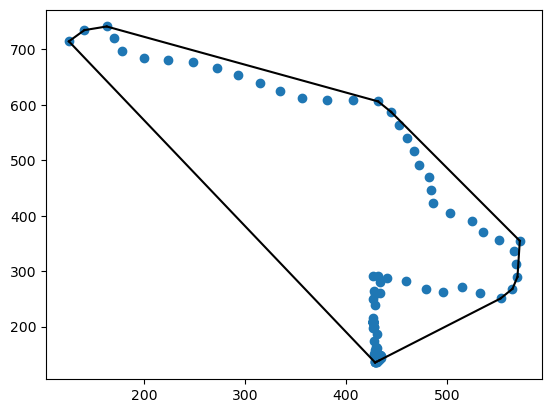

In [37]:
points = np.array(telemetry_c_0)
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [38]:
df_t.loc[len(df_t.index)] = convex_hull
df_t

,mopoz,dav1g,alex,SunPayus,DeathZz
0,"(125.66692741549744, 714.4287358498086)","(101.81441326530611, 687.887629294882)","(118.89097875478315, 704.5327509665975)","(98.58139349489795, 723.9911885164221)","(86.60148776307398, 664.8735575773278)"
1,"(140.99362743144133, 734.7094103754782)","(112.11562798947703, 706.9494815748565)","(130.60621611926018, 726.4120296556122)","(119.86589704241071, 737.1476589903539)","(97.42974728954081, 686.1301655672034)"
2,"(163.0840441645408, 741.2921983368542)","(129.04767717633928, 725.7706311284279)","(149.0907505580357, 743.4165394062898)","(141.9268176020408, 749.7388847506776)","(112.54705935108417, 705.0971517757494)"
3,"(170.5626444913903, 720.6623186383928)","(147.2238221460459, 742.4029883559868)","(167.92871591996172, 737.0785584741709)","(158.19066884566325, 746.4728748555085)","(126.3080207669005, 724.4992439114317)"
4,"(178.49801199776783, 697.5711931501115)","(167.18859614158163, 737.662929612763)","(173.87005241549744, 713.9824816645407)","(170.38051060267856, 726.1575753348213)","(143.38197046396684, 740.8494910415337)"
...,...,...,...,...,...
138,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.7493124202806, 234.88321109693877)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
139,1288.075528,1527.494573,1688.643635,1137.213275,1549.59762
140,589.046136,351.46774,651.725896,703.985153,354.760691
141,0.457307,0.230094,0.385946,0.619044,0.228937


### adding Hulls Centroids once for x and once for y values

In [39]:
hull_centroids_x = np.array([x[0] for x in hull_centroids])
hull_centroids_y = np.array([x[1] for x in hull_centroids])

In [40]:
hull_centroids

array([[406.78857163, 391.83750195],
       [377.68344143, 547.42371681],
       [371.94922495, 424.77365214],
       [412.59504954, 420.73707477],
       [363.7358729 , 532.82885514]])

In [41]:
# adding the centroid of convex hull

df_t.loc[len(df_t.index)] = hull_centroids_x
df_t.loc[len(df_t.index)] = hull_centroids_y
df_t.tail(10)

,mopoz,dav1g,alex,SunPayus,DeathZz
135,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(572.9141920440051, 250.79704440369895)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
136,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3059480628189, 226.5763014190051)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
137,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3247942243303, 219.0591119260204)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
138,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.7493124202806, 234.88321109693877)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
139,1288.075528,1527.494573,1688.643635,1137.213275,1549.59762
140,589.046136,351.46774,651.725896,703.985153,354.760691
141,0.457307,0.230094,0.385946,0.619044,0.228937
142,118209.957893,83794.898711,142084.808688,94957.055621,66360.338352
143,406.788572,377.683441,371.949225,412.59505,363.735873
144,391.837502,547.423717,424.773652,420.737075,532.828855


## Now lets rename the row indices to the time for the trajectories and the metrics for the appended rows

In [42]:
new_index = list(np.arange(0.375, 0.375+0.5*139, 0.5))
new_index.append("total_distance")
new_index.append("start_to_end_distance")
new_index.append("total_to_start-to-end_ratio")
new_index.append("covered_area (convex_hull)")
new_index.append("centroid_x")
new_index.append("centroid_y")
df_t.index = new_index

df_t.tail(10)

,mopoz,dav1g,alex,SunPayus,DeathZz
67.875,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(572.9141920440051, 250.79704440369895)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
68.375,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3059480628189, 226.5763014190051)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
68.875,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.3247942243303, 219.0591119260204)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
69.375,"(426.7575104382573, 208.1483677455357)","(409.69762841049504, 518.3662507971939)","(570.7493124202806, 234.88321109693877)","(589.7716413225446, 219.6825175382653)","(409.6975240902025, 518.3672472895407)"
total_distance,1288.075528,1527.494573,1688.643635,1137.213275,1549.59762
start_to_end_distance,589.046136,351.46774,651.725896,703.985153,354.760691
total_to_start-to-end_ratio,0.457307,0.230094,0.385946,0.619044,0.228937
covered_area (convex_hull),118209.957893,83794.898711,142084.808688,94957.055621,66360.338352
centroid_x,406.788572,377.683441,371.949225,412.59505,363.735873
centroid_y,391.837502,547.423717,424.773652,420.737075,532.828855
